# Variational autoencoder

In [13]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
#load data
batch_size = 4
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=1)

torch.Size([3, 32, 122])


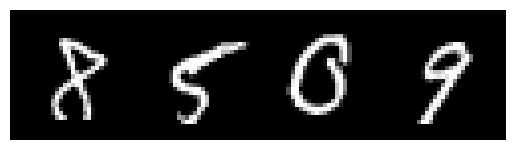

8     5     0     9    


In [15]:
#show original images
def imshow(img):
    print(img.shape)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
classes = list(str(i) for i in range(10))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [16]:
#define model, VAE
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        #encoder
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(128, 20)
        #decoder
        self.fc4 = nn.Linear(20, 128)
        self.fc5 = nn.Linear(128, 28*28)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu, log_var = self.fc2(x), self.fc3(x)
        y = self.reparameterize(mu, log_var)
        x = F.relu(self.fc4(y))
        x = torch.sigmoid(self.fc5(x))
        return x, mu, log_var

In [17]:
#initialize model
w = torch.empty(3, 5)
nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
net_vae = VariationalAutoEncoder()

In [18]:
#define loss function and optimizer
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_vae.parameters(), lr=0.001)

In [19]:
#train model
n_epoch = 2
for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device).view(-1, 28*28)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, mu, log_var  = net_vae(inputs)
        loss_ = F.binary_cross_entropy(outputs, inputs, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = loss_ + kl_div
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss
        if i % 12000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 697.122
[1, 14000] loss: 3019.231
[2,  2000] loss: 468.965
[2, 14000] loss: 2786.533
Finished Training


Text(0.5, 0.98, 'Original and atuoencoded images')

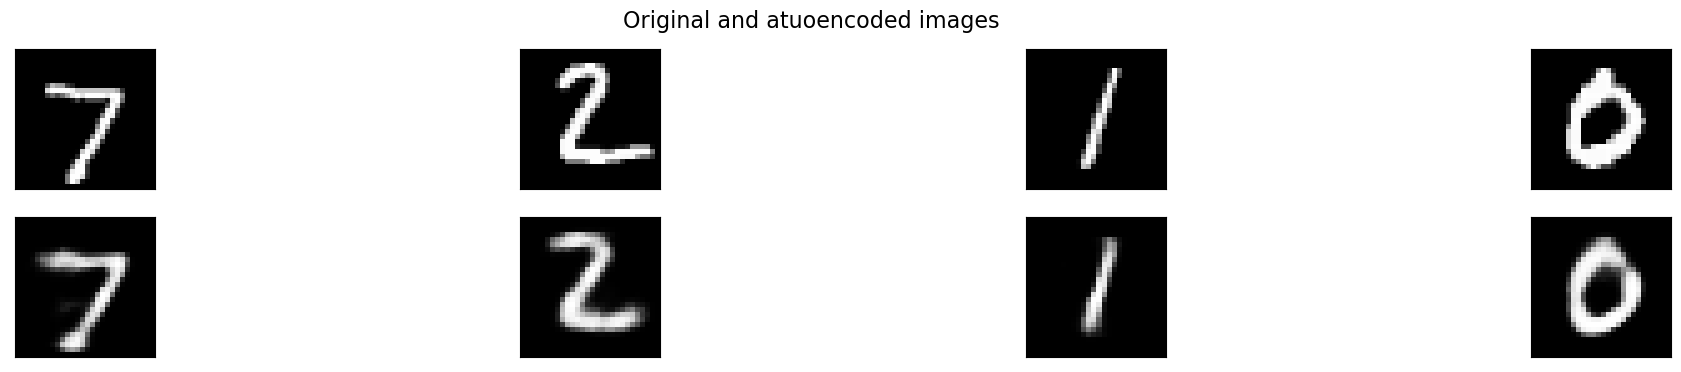

In [20]:
#evaluate model
dataiter = iter(testloader)
inputs, labels = dataiter.next()

# get sample outputs
inputs = inputs.to(device).view(-1, 28*28)
outputs, mu, log_var = net_vae(inputs)
inputs = inputs.view(-1, 1, 28, 28)
outputs = outputs.view(-1, 1, 28, 28)
outputs = outputs.detach().numpy()

#show images
fig, axes = plt.subplots(nrows=2, ncols=batch_size, sharex=True, sharey=True, figsize=(25,4))
for img, row in zip([inputs, outputs], axes):
    for img, ax in zip(img, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.suptitle('Original and atuoencoded images', fontsize=16)

In [21]:
#make subsets and loaders based on classes
#subsets = {target: Subset(testset, [i for i, (x, y) in enumerate(testset) if y == target]) for _, target in testset.class_to_idx.items()}
#loaders = {target: DataLoader(subset) for target, subset in subsets.items()}

In [22]:
#get interpolation between pairs of test images
dataset_ls_same = []
dataset_ls_diff = []
nrows = 10
n_test = len(testset)
for c in range(nrows):
    #get pair of the same digits
    digit = random.randint(0, 9)
    ls_same = []
    for i, (x, y) in enumerate(testset):
        if y == digit:
            ls_same.append((x, y))
    n = len(ls_same)
    j0 = j1 = 0
    while j0 == j1:
        j0, j1 = random.randint(0,n-1),random.randint(0,n-1)
    data0, data1 = ls_same[j0], ls_same[j1]
    diff = (data1[0] - data0[0])/7.
    data_ls = [data0[0]]
    for i in range(7):
        tmp = data_ls[-1] + diff
        data_ls.append(tmp)
    data_ls.append(data1[0])
    dataset_ls_same.append(data_ls)
    
    #get pair of the different digits
    digit0 = digit1 = 0
    k0 = k1 = 0
    while digit0 == digit1:
        k0, k1 = random.randint(0,n_test-1),random.randint(0,n_test-1)
        digit0, digit1 = testset[k0][1], testset[k1][1]
    data2, data3 = testset[k0], testset[k1]
    diff = (data3[0] - data2[0])/7.
    data_ls_diff = [data2[0]]
    for i in range(7):
        tmp = data_ls_diff[-1] + diff
        data_ls_diff.append(tmp)
    data_ls_diff.append(data3[0])
    dataset_ls_diff.append(data_ls_diff)

Text(0.5, 0.98, 'Original test and interpolation images(same digits)')

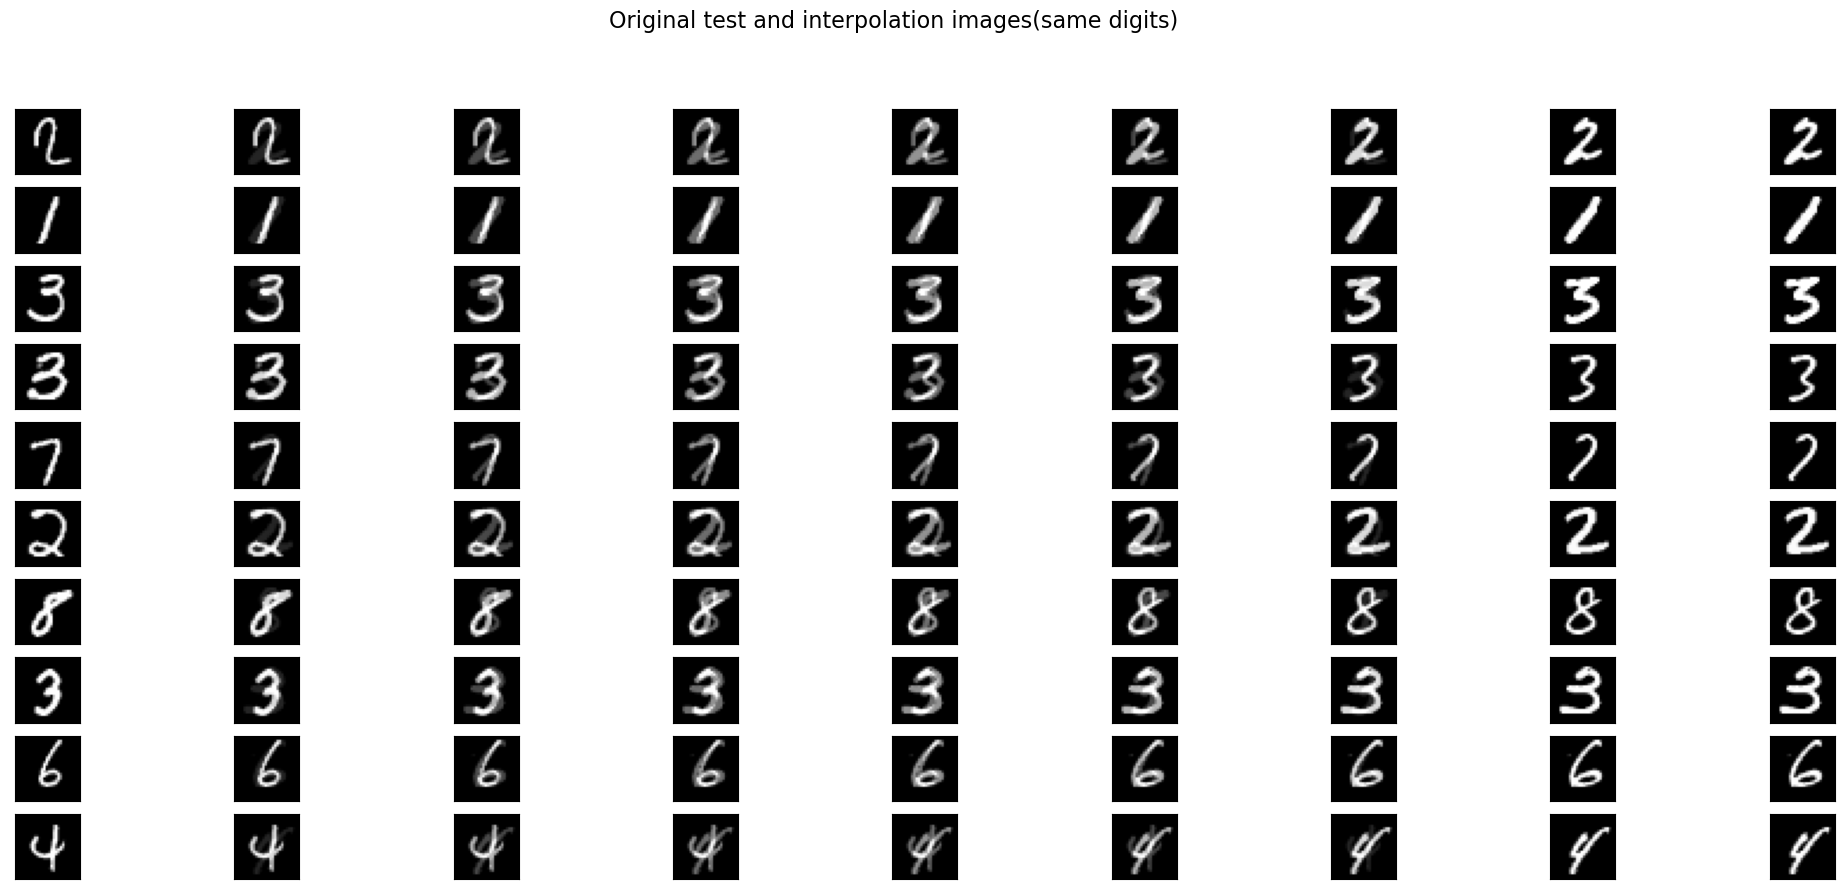

In [23]:
#show test and intepolate images, same digits
ncols = len(dataset_ls_same[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(25,10))
for imgs, row in zip(dataset_ls_same, axes):
    for img, ax in zip(imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.suptitle('Original test and interpolation images(same digits)', fontsize=16)

Text(0.5, 0.98, 'Original test and interpolation images(different digits)')

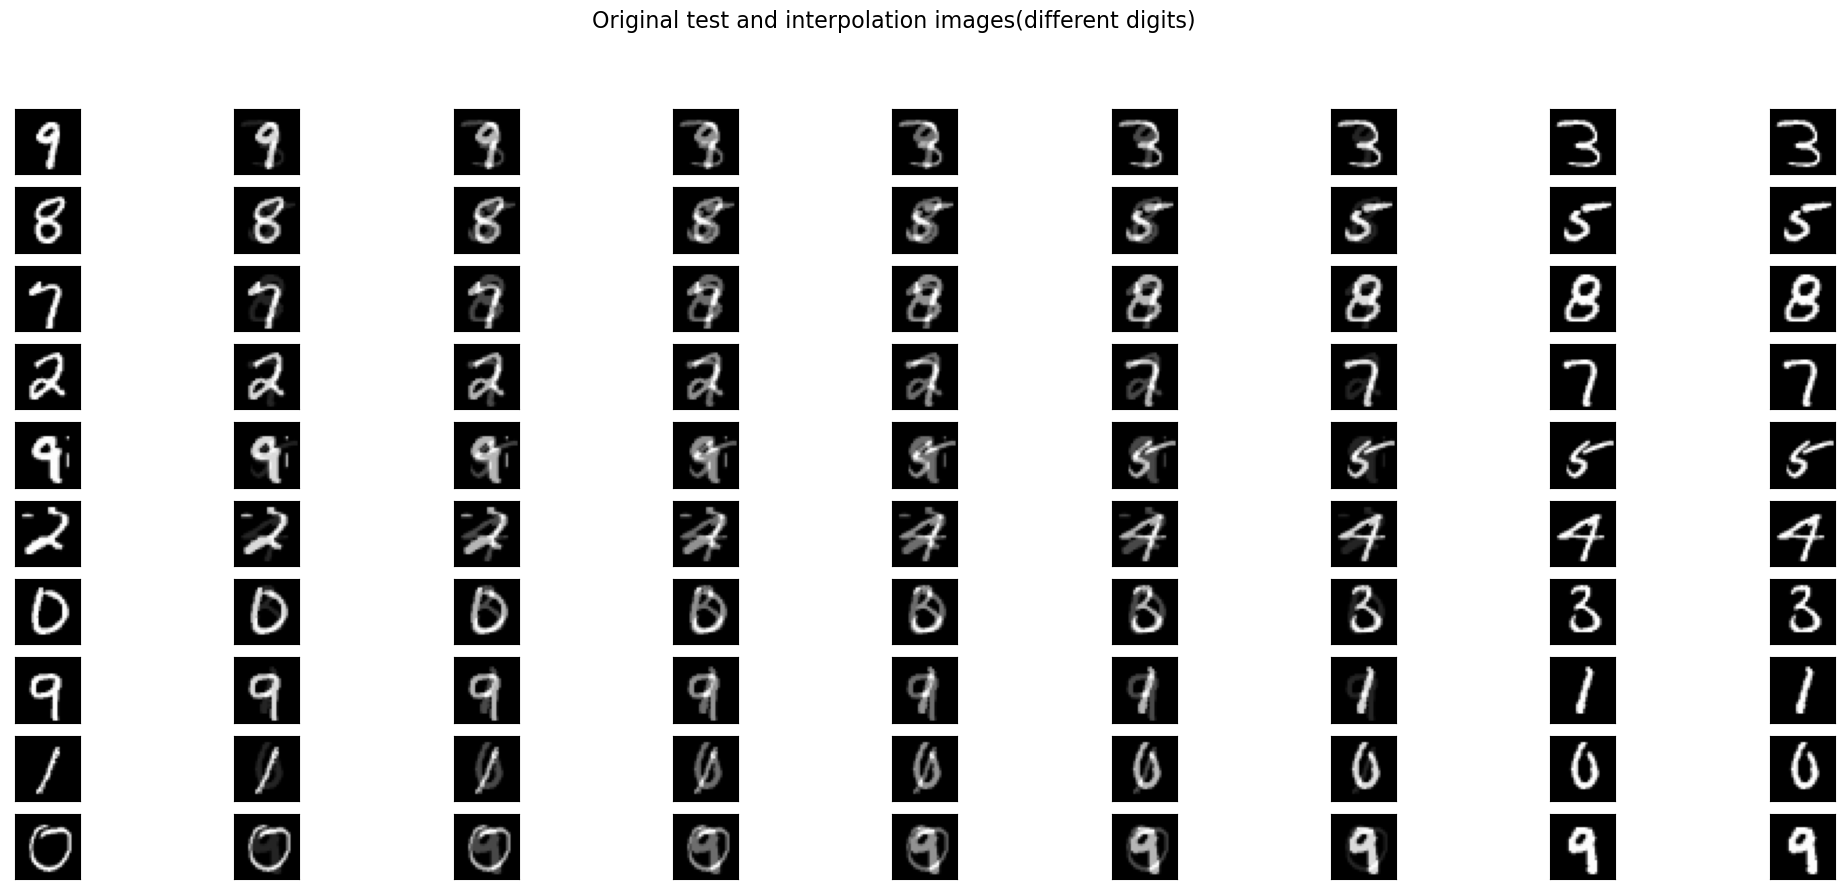

In [24]:
#show test and intepolate images, different digits
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(25,10))
for imgs, row in zip(dataset_ls_diff, axes):
    for img, ax in zip(imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.suptitle('Original test and interpolation images(different digits)', fontsize=16)

Text(0.5, 0.98, 'Autoencoded test and interpolation images(same digits)')

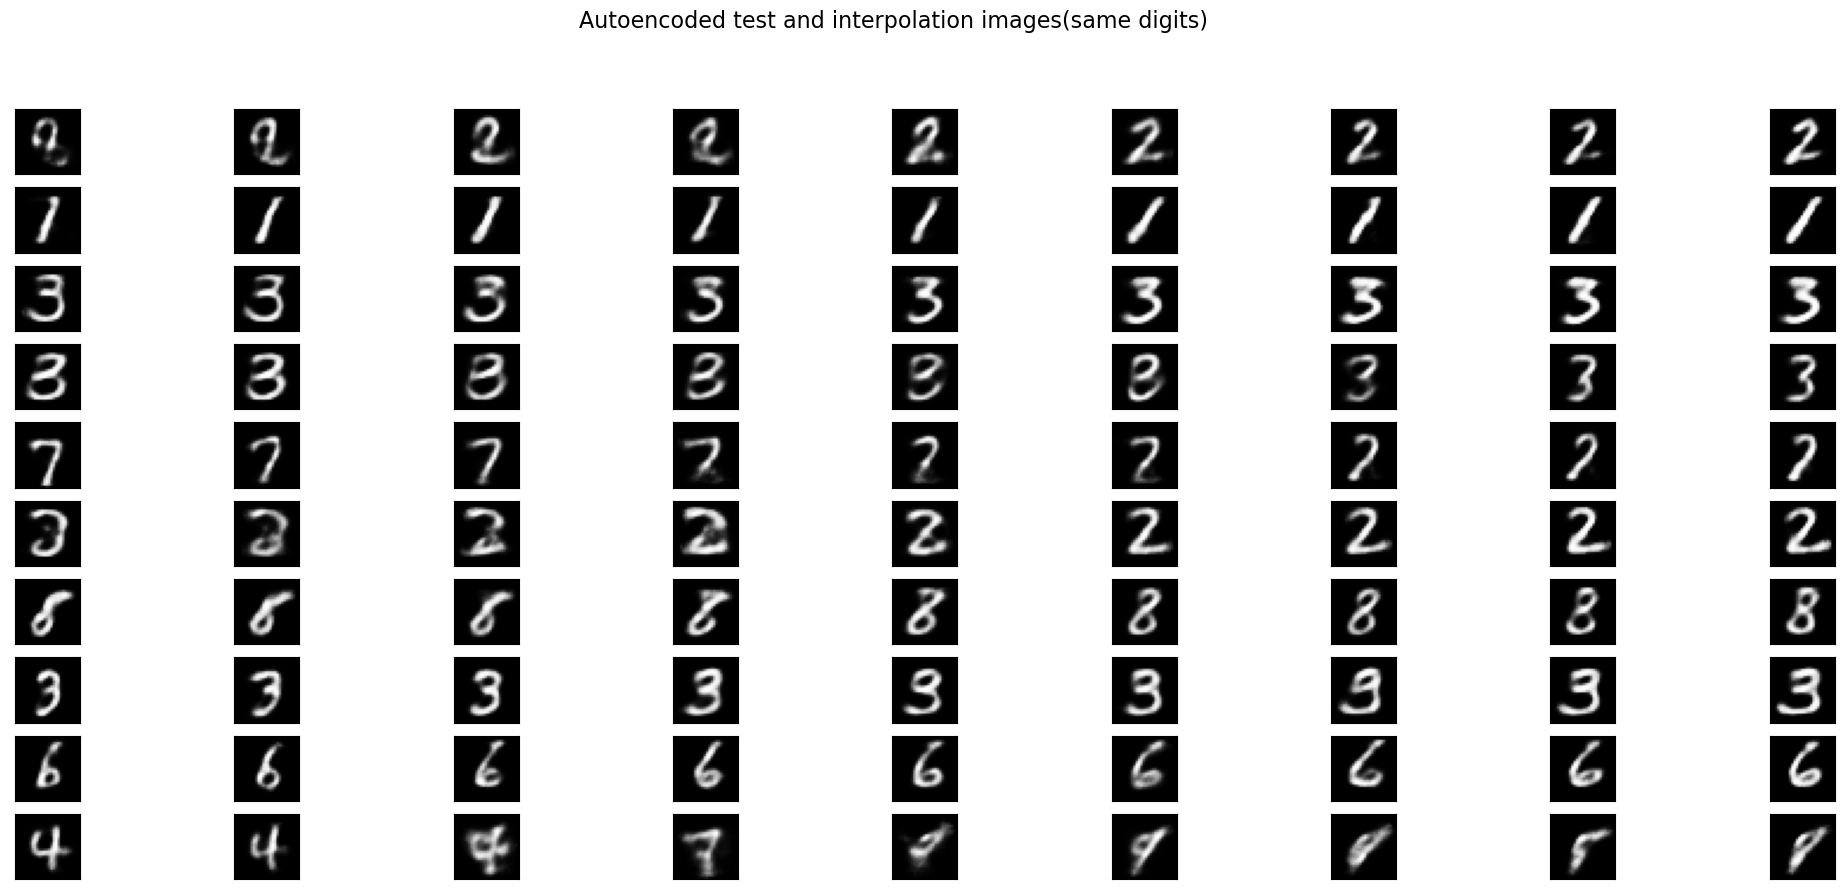

In [25]:
#test model
res_same = []
with torch.no_grad():
    for ls_same in dataset_ls_same:
        output_tmp = []
        for input_ in ls_same:
            input_ = input_.to(device).view(-1, 28*28)
            output, mu, log_var = net_vae(input_)
            output = output.view(-1, 1, 28, 28)
            output = output.detach().numpy()
            output_tmp.append(output)
        res_same.append(output_tmp)

#show autoencoded images
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(25,10))
for imgs, row in zip(res_same, axes):
    for img, ax in zip(imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.suptitle('Autoencoded test and interpolation images(same digits)', fontsize=16)

Text(0.5, 0.98, 'Autoencoded test and interpolation images(different digits)')

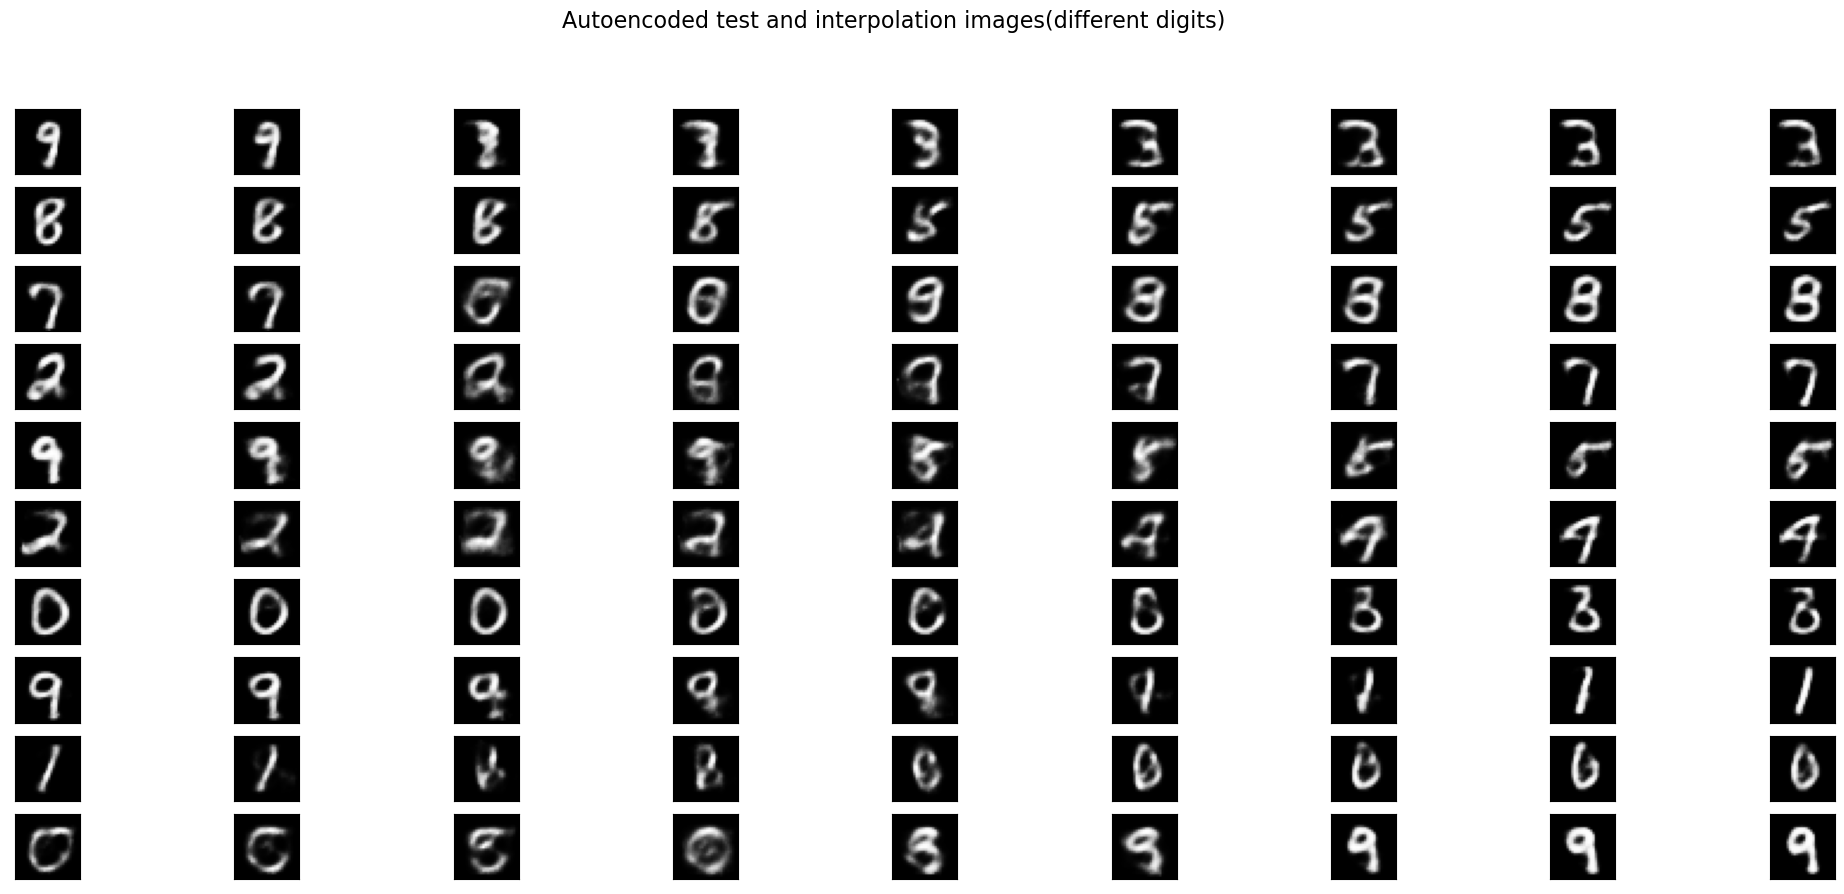

In [26]:
#test model
res_diff = []
with torch.no_grad():
    for ls_diff in dataset_ls_diff:
        output_tmp = []
        for input_ in ls_diff:
            input_ = input_.to(device).view(-1, 28*28)
            output, mu, log_var = net_vae(input_)
            output = output.view(-1, 1, 28, 28)
            output = output.detach().numpy()
            output_tmp.append(output)
        res_diff.append(output_tmp)

#show autoencoded images
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(25,10))
for imgs, row in zip(res_diff, axes):
    for img, ax in zip(imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.suptitle('Autoencoded test and interpolation images(different digits)', fontsize=16)